# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import import_ipynb
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

import Utility
from Utility import *

importing Jupyter notebook from Utility.ipynb


 ## Read Music Data

In [2]:
tracks = pd.read_csv(r"datasets/data.csv")

## Content-based Filtering Song Recommendation


Content-based filtering uses similarities in products, services, or content features, as well as information accumulated about the user to make recommendations. In our case we have created a recommendation system which recommends songs based on similar songs.
Music Recommender based on different KMeans and PCA algorithm

1. **PCA_algorithm**: to reduce the dimensionality (in our case number of components is 2) within a dataset while still retaining as much information as possible.

2. **KMeans_with_PCA_algorithm**: algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping clusters. 
    Based on the values of the Within Cluster Sum of Squares (WCSS) and an approach known as the Elbow method, we made a decision about how many clusters we’d like to keep.In our case, we have kept number of cluster as 3.

3. we have then created a new data frame df_segm_pca_kmeans. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them com1 and com2.

4. **filter_based_on_segment**: filters songs that belong to particulat cluster segment.

5. **filter_based_on_cluster_centroid**: filters songs based on closet distance of song and centroid


In [30]:
def recommend_songs(song_id, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    song_embedding = PCA_algorithm(tracks)
    
    kmeans_pca , centroids = KMeans_with_PCA_algorithm(song_embedding,3)

    #get Segment K-means PCA from song_id argument
    df_segm_pca_kmeans = pd.concat([tracks.reset_index(drop=True), pd.DataFrame(song_embedding)],axis=1)
    df_segm_pca_kmeans.columns.values[-2:] = ['com1','com2']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    #get segment value of song_id
    segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['id'] == song_id]['Segment K-means PCA'].values[0]
    
    filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans,segment_val,'id', 'name')   

    rec_songs = filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,tracks)

    #recommend top n songs
    return rec_songs.head(n_songs)['name'].tolist()

In [25]:
song_embedding = PCA_algorithm(tracks)
    
kmeans_pca , centroids = KMeans_with_PCA_algorithm(song_embedding,3)

#get Segment K-means PCA from song_id argument
df_segm_pca_kmeans = pd.concat([tracks.reset_index(drop=True), pd.DataFrame(song_embedding)],axis=1)
df_segm_pca_kmeans.columns.values[-2:] = ['com1','com2']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

#get segment value of song_id
segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['id'] == '3w3cxwYuR7ThpE8KVSys5x']['Segment K-means PCA'].values[0]

filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans,segment_val,'id', 'name')   

rec_songs = filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,tracks)

print(rec_songs.head(10))

                            id  \
41392   155fIKsgEWbNrcCMjcLbZz   
4653    6ckro7vrZwBfKgSO0ElhfH   
155735  7vFIJg1ix4MkwtNVFxsmW7   
39602   3jQJ9sL40ysef9XW1UJWEx   
57745   3xHpx7oDetu7uempkFKR3W   
61792   04gZ18dV6O3Vs2gZa3G2Hv   
157641  60nL3rZ4gqLd04f0GF9yyw   
24407   0joz0J52hKwjOyMqscaE8z   
93196   796LQCCQrzHuAypHVA6RVu   
59501   5s6om9krIEqmr2dbCsfr0C   

                                                     name      com1      com2  \
41392                              Se ksexasa den se pono  1.166991 -1.535007   
4653                          Tacos, Enchiladas And Beans  1.168941 -1.530111   
155735                                  MIkri gitonopoula  1.171422 -1.542669   
39602       Flor Deshojada - Instrumental (Remasterizado)  1.174710 -1.543745   
57745               Opening Act II: Sports of Gay Chicago  1.181555 -1.537291   
61792                               My Little Her and Him  1.182034 -1.540792   
157641  Be My Little Baby Bumble Bee (with Paul Weston... 

C:\Users\shris\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Finds similar songs based on the selected song using its song_id 
Recommends Top N song(s). In  our case, we have recommended top 10 songs

In [31]:
recommend_songs_list = recommend_songs("3w3cxwYuR7ThpE8KVSys5x")
recommend_songs_list

C:\Users\shris\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


['The Sentimental Touch',
 "Beulah's Boogie",
 'Stew Ball',
 'Was I Wazir?',
 'Sonora Querida',
 'Hava Nagila (Sung in Hungarian)',
 'Opening Act II: Sports of Gay Chicago',
 'My Little Her and Him',
 'Pravazhanye (Parting)',
 'Nanu Paalimpaga']

In [5]:
# import plotly.express as px
# fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
# fig.show()

In [6]:
# df = pd.read_csv(r"C:/Users/shris/Desktop/profiles.csv")
# print(df.gender)
# df.columns = ['userid', 'gender', 'age', 'country']

In [7]:
# df.head()

In [8]:
# songs = df.gender.tolist()
# output = {}
# outputs = []
# for song in songs:
#     k = recommend_songs(song)
#     output.update( {song : k})


In [9]:
# output

In [10]:
# df1 = pd.DataFrame.from_dict(output, orient='index')

In [14]:
pip install circlify

Note: you may need to restart the kernel to use updated packages.


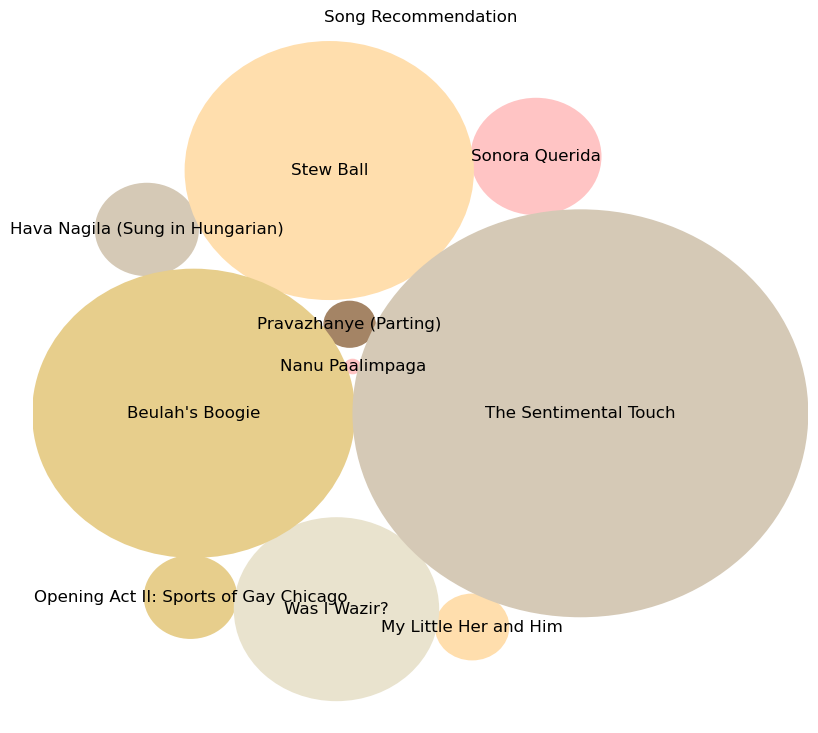

In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import circlify
from matplotlib.offsetbox import AnnotationBbox

df = pd.DataFrame({'Name': recommend_songs_list,
                   'Value': [1000, 500, 400, 200, 80, 50, 40, 25, 12, 1]})
df = df.sort_values('Value') 
circles = circlify.circlify(df['Value'].tolist(),
                            target_enclosure=circlify.Circle(x=0, y=0, r=1))

fig, ax = plt.subplots(figsize=(10, 9))

ax.set_title('Song Recommendation')
ax.axis('off')  

lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r, )
          for circle in circles)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

labels = df['Name']  
colors = ['#ffc4c4','#a48465','#ffdead','#e7ce8c','#d5c9b6','#ffc4c4','#e9e3ce','#ffdead','#e7ce8c','#d5c9b6']
for circle, label, color in zip(circles, labels, colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, linewidth=2, color=color))
    ax.annotate(label, (x, y), va='center', ha='center', size=12)
plt.show()

In [148]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

dataset = tracks
dataset.artists = dataset.artists.astype(str)

for column in dataset.columns:
    temp_new = le.fit_transform(dataset[column].astype('category'))
    dataset.drop(labels=[column], axis="columns", inplace=True)
    dataset[column] = temp_new

X = dataset[["artists"]]
Y = dataset[["name"]]

model = DecisionTreeClassifier()
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

model.fit(X_train,Y_train)

score = metrics.accuracy_score(Y_test,k_means.predict(X_test))
print('Accuracy:{0:f}'.format(score))

print(k_means.predict(X_test))
print(k_means.labels_[:])
print(y_test[:])


KeyError: "None of [Index(['name'], dtype='object')] are in the [columns]"

In [ ]:


X_train, X_test,y_train,y_test =  cross_validation.train_test_split(X,y,test_size=0.20,random_state=70)
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(num_datatypes)
print(k_means.labels_[:])
print(y_train[:])

score = metrics.accuracy_score(y_test,k_means.predict(X_test))
print('Accuracy:{0:f}'.format(score))

print(k_means.predict(X_test))
print(k_means.labels_[:])
print(y_test[:])